# Playground

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import sys

if '../..' not in sys.path:
    sys.path.append('../..')
    
from data import OneBallFreeFallThreeFramesDataset

In [2]:
train_data, test_data = OneBallFreeFallThreeFramesDataset.train_test_split('../../data/raw/single-ball-free-fall', test_frac=0.3)

train_test_split response: test fraction rounded to 0.2999440402909905 (1608 simulations)


In [3]:
batch_size = 1

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Dense Network

In [4]:
class Dense1DFreeFallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(3, 2)
        self.output = nn.Linear(2, 1)
        
    
    def forward(self, x):
        x = self.hidden(x)
        x = nn.functional.relu(x)
        x = self.output(x)
        x = nn.functional.relu(x)
        return x

In [5]:
model = Dense1DFreeFallModel()

print(model)

Dense1DFreeFallModel(
  (hidden): Linear(in_features=3, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
)


In [6]:
learning_rate = 0.1

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
num_epochs = 100

loss_items = []
loss_per_epoch = []

epoch_loss = 0
test_epoch_loss = 0

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        optimizer.zero_grad()
        
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_items.append(loss.item())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    loss_per_epoch.append(epoch_loss)
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    epoch_loss = 0

Epoch 0 complete. Training loss: 6.133240893402814
Epoch 1 complete. Training loss: 2.2076572133534853
Epoch 2 complete. Training loss: 2.0564601099588167
Epoch 3 complete. Training loss: 1.9436799506097957
Epoch 4 complete. Training loss: 1.8363346021858948
Epoch 5 complete. Training loss: 1.7353805982615853
Epoch 6 complete. Training loss: 1.6457585468562037
Epoch 7 complete. Training loss: 1.5706164615215086
Epoch 8 complete. Training loss: 1.510316317107024
Epoch 9 complete. Training loss: 1.4633670708488857
Epoch 10 complete. Training loss: 1.427889137324918
Epoch 11 complete. Training loss: 1.4016056411809785
Epoch 12 complete. Training loss: 1.3827469436539133
Epoch 13 complete. Training loss: 1.3698023957133998
Epoch 14 complete. Training loss: 1.360818248302376
Epoch 15 complete. Training loss: 1.3545653463905047
Epoch 16 complete. Training loss: 1.3505285672762426
Epoch 17 complete. Training loss: 1.3478329037859735
Epoch 18 complete. Training loss: 1.3461038883110326
Epoch 1

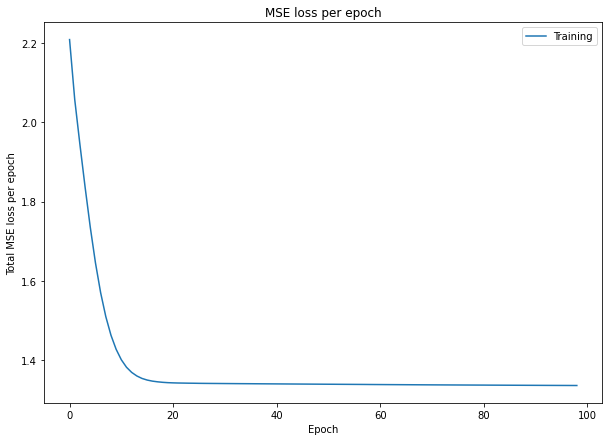

In [8]:
plt.figure(figsize=(10,7))
plt.plot(loss_per_epoch[1:], label='Training')
plt.title('MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Total MSE loss per epoch')
plt.legend()
plt.show()

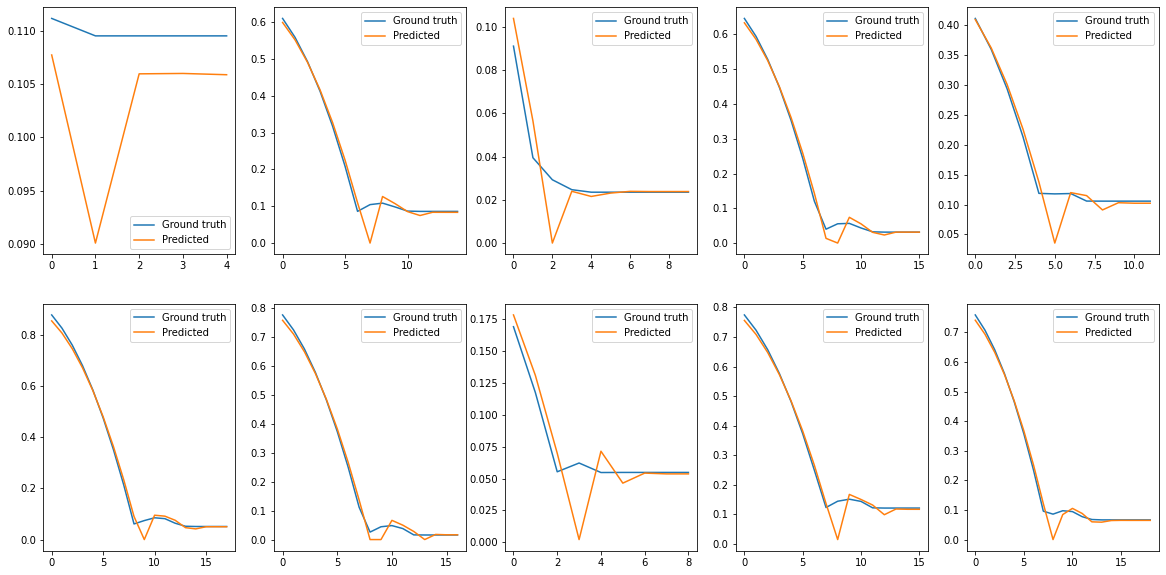

In [9]:
count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model(X)
        axs[int(count >= 5)][count % 5].plot(y.reshape(1,-1)[0], label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(pred.reshape(1,-1)[0], label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

# Linear with ctg activation for velocity

In [10]:
def ctg(x):
    return 1 / torch.tan(x)

class LinearWithCtgVelocity1DFreeFallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.velocity = nn.Linear(3,1)
        self.acceleration = nn.Linear(3,1)
        nn.init.kaiming_uniform_(self.velocity.weight)
        nn.init.kaiming_uniform_(self.acceleration.weight)
        self.output = nn.Linear(2,1)
        
    
    def forward(self, x):
        v = ctg(self.velocity(x))
        g = nn.functional.relu(self.acceleration(x))
        x = torch.cat((v, g), dim=2)
        x = self.output(x)
        x = nn.functional.relu(x)
        return x

In [21]:
model2 = LinearWithCtgVelocity1DFreeFallModel()
print(model2)

LinearWithCtgVelocity1DFreeFallModel(
  (velocity): Linear(in_features=3, out_features=1, bias=True)
  (acceleration): Linear(in_features=3, out_features=1, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
)


In [22]:
learning_rate = 0.1

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)

In [23]:
num_epochs = 100

loss_items = []
loss_per_epoch = []

epoch_loss = 0
test_epoch_loss = 0

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        optimizer.zero_grad()
        
        pred = model2(X)
        loss = loss_fn(pred, y)
        loss_items.append(loss.item())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    loss_per_epoch.append(epoch_loss)
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    epoch_loss = 0

Epoch 0 complete. Training loss: 108.75944657784976
Epoch 1 complete. Training loss: 10.142297422115917
Epoch 2 complete. Training loss: 6.389985871116465
Epoch 3 complete. Training loss: 3.3820635208687158
Epoch 4 complete. Training loss: 1.8403237769819043
Epoch 5 complete. Training loss: 1.5219339551877402
Epoch 6 complete. Training loss: 1.4560695627903897
Epoch 7 complete. Training loss: 1.4187350250076065
Epoch 8 complete. Training loss: 1.3861733174831983
Epoch 9 complete. Training loss: 1.3560749814912754
Epoch 10 complete. Training loss: 1.3280608140598105
Epoch 11 complete. Training loss: 1.302120681770404
Epoch 12 complete. Training loss: 1.2781511252864206
Epoch 13 complete. Training loss: 1.2560313911747372
Epoch 14 complete. Training loss: 1.2359546223150062
Epoch 15 complete. Training loss: 1.217856572944914
Epoch 16 complete. Training loss: 1.2017263553216821
Epoch 17 complete. Training loss: 1.187393962205448
Epoch 18 complete. Training loss: 1.1749962930092366
Epoch 1

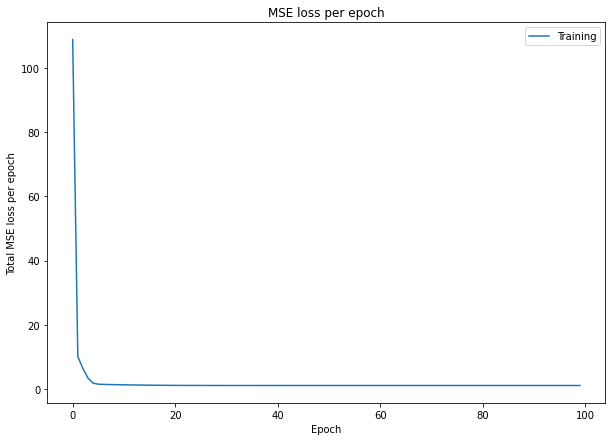

In [26]:
plt.figure(figsize=(10,7))
plt.plot(loss_per_epoch, label='Training')
plt.title('MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Total MSE loss per epoch')
plt.legend()
plt.show()

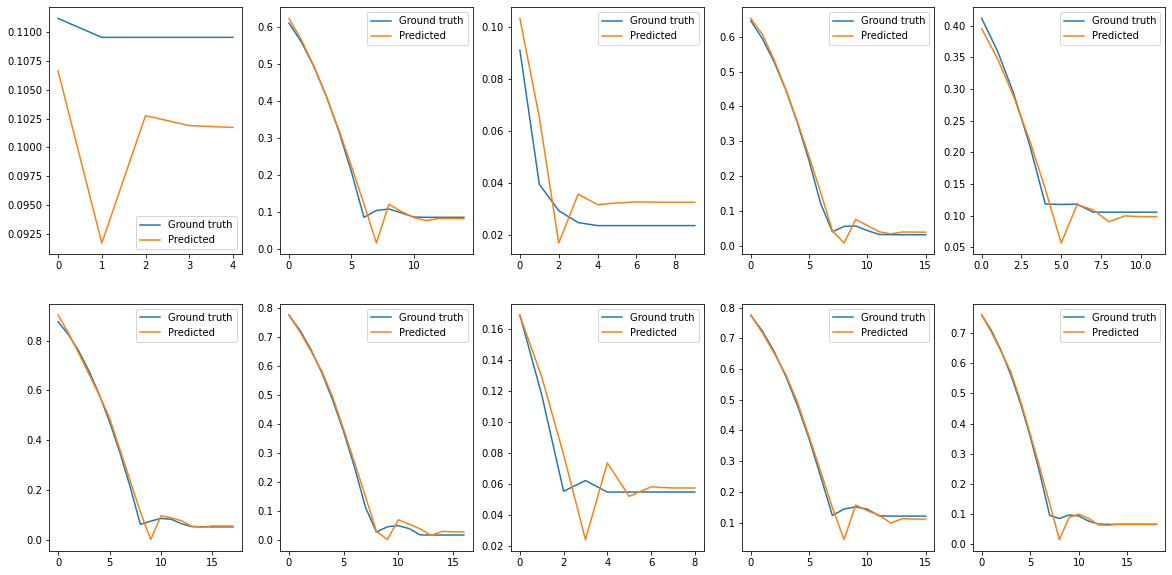

In [27]:
count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model2(X)
        axs[int(count >= 5)][count % 5].plot(y.reshape(1,-1)[0], label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(pred.reshape(1,-1)[0], label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

# Custom with third coordinate connected to output

In [28]:
class Kinem1DFreeFallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(3, 2)
        nn.init.kaiming_uniform_(self.hidden.weight, nonlinearity='relu')
        self.output = nn.Linear(3,1)
        
    
    def forward(self, x):
        out = nn.functional.relu(self.hidden(x))
        out = torch.cat((out, x[0,:,-1].reshape(-1,1).unsqueeze(dim=0)), dim=2)
        out = self.output(out)
        out = nn.functional.relu(out)
        return out

In [29]:
model3 = Kinem1DFreeFallModel()
print(model3)

Kinem1DFreeFallModel(
  (hidden): Linear(in_features=3, out_features=2, bias=True)
  (output): Linear(in_features=3, out_features=1, bias=True)
)


In [30]:
learning_rate = 0.1

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate)

In [31]:
num_epochs = 100

loss_items = []
loss_per_epoch = []

epoch_loss = 0
test_epoch_loss = 0

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        optimizer.zero_grad()
        
        pred = model3(X)
        loss = loss_fn(pred, y)
        loss_items.append(loss.item())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    loss_per_epoch.append(epoch_loss)
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    epoch_loss = 0

Epoch 0 complete. Training loss: 9.021436990497477
Epoch 1 complete. Training loss: 3.9880942830907316
Epoch 2 complete. Training loss: 3.243192543639399
Epoch 3 complete. Training loss: 2.5040341145767115
Epoch 4 complete. Training loss: 1.9421540329780953
Epoch 5 complete. Training loss: 1.7118392233894388
Epoch 6 complete. Training loss: 1.6380654589137968
Epoch 7 complete. Training loss: 1.6104512676352534
Epoch 8 complete. Training loss: 1.5921129244188879
Epoch 9 complete. Training loss: 1.5758162782267036
Epoch 10 complete. Training loss: 1.5599701481775128
Epoch 11 complete. Training loss: 1.5442679863036979
Epoch 12 complete. Training loss: 1.5287602526561583
Epoch 13 complete. Training loss: 1.5136155456721054
Epoch 14 complete. Training loss: 1.4985517313396601
Epoch 15 complete. Training loss: 1.483742579955727
Epoch 16 complete. Training loss: 1.4694951961951475
Epoch 17 complete. Training loss: 1.4557778747237324
Epoch 18 complete. Training loss: 1.4426568623196978
Epoch 

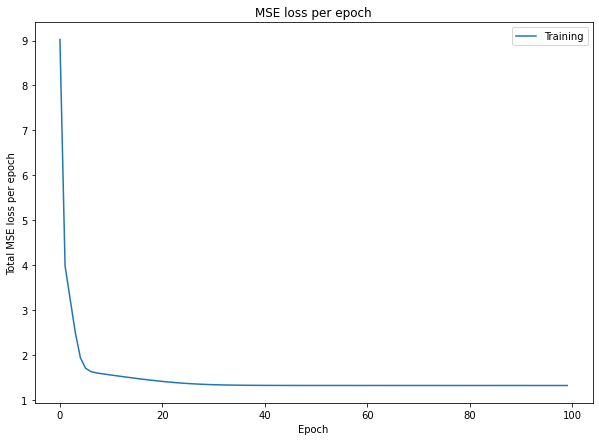

In [32]:
plt.figure(figsize=(10,7))
plt.plot(loss_per_epoch, label='Training')
plt.title('MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Total MSE loss per epoch')
plt.legend()
plt.show()

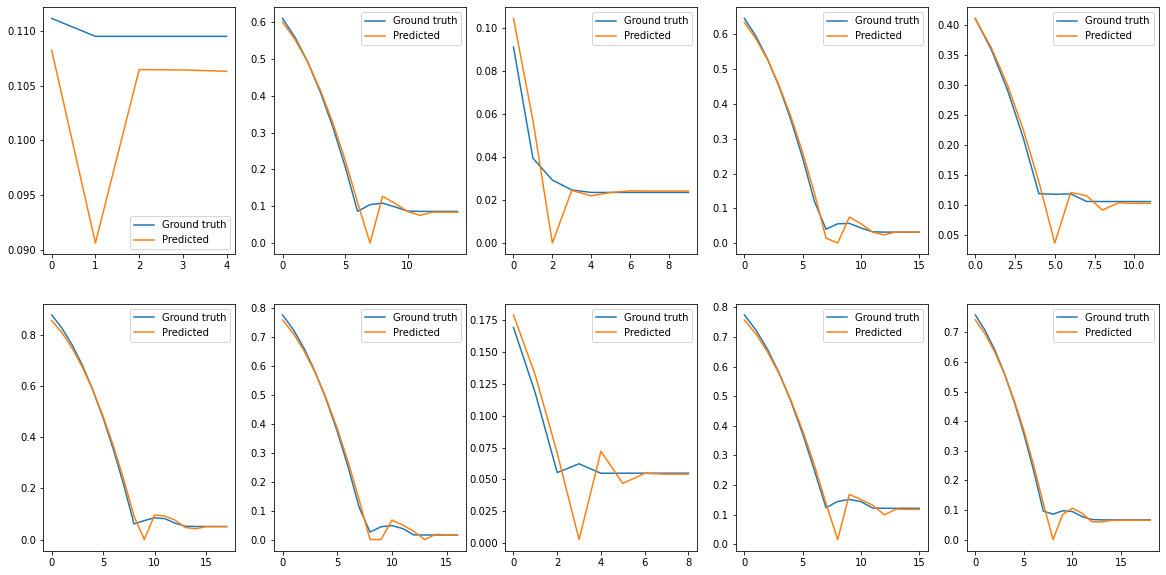

In [33]:
count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model3(X)
        axs[int(count >= 5)][count % 5].plot(y.reshape(1,-1)[0], label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(pred.reshape(1,-1)[0], label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1